
================================================================================

PROJET DATA SCIENCE - PRÉDICTION DU CHURN TÉLÉCOM

================================================================================







Étape 1 : Choix du problème


================================================================================

CONTEXTE :
Une entreprise de télécommunications fait face à un taux d'attrition élevé.
L'objectif est d'identifier les clients à risque pour mettre en place des actions de rétention ciblées.

OBJECTIFS :
- Atteindre une précision de prédiction d'au moins 80%
- Identifier correctement 75% des clients qui vont partir
- Réduire le taux d'attrition de 15%

================================================================================

============================================================================

Étape 2 : Exploration des données

============================================================================




import des libraries

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings

warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Bibliothèques importées avec succès!")


✅ Bibliothèques importées avec succès!



CHARGEMENT DES DONNÉES


In [71]:
try:
    data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("✅ Données chargées avec succès!")
except FileNotFoundError:
    print("❌ ERREUR : Fichier non trouvé!")
    print("\n📋 INSTRUCTIONS :")
    print("1. Allez sur : https://www.kaggle.com/datasets/blastchar/telco-customer-churn")
    print("2. Téléchargez le fichier CSV")
    print("3. Placez-le dans le même dossier que ce script")
    print("4. Relancez le script")
    exit()

✅ Données chargées avec succès!


EXPLORATION INITIALE


Nombres de lignes et de colonnes

In [72]:
print("\n📊 DIMENSIONS DU DATASET :")
print(f"   Nombre de lignes (clients) : {data.shape[0]}")
print(f"   Nombre de colonnes (variables) : {data.shape[1]}")


📊 DIMENSIONS DU DATASET :
   Nombre de lignes (clients) : 7043
   Nombre de colonnes (variables) : 21


Les types de données

In [73]:
print("\n🔍 INFORMATIONS SUR LES TYPES DE DONNÉES :")
print(data.info())


🔍 INFORMATIONS SUR LES TYPES DE DONNÉES :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16 

Les statistiques de base

In [74]:
print("\n📈 STATISTIQUES DESCRIPTIVES (variables numériques) :")
print(data.describe())


📈 STATISTIQUES DESCRIPTIVES (variables numériques) :
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


Le nombre d'observation et de variables

In [75]:
print("\n🎯 DISTRIBUTION DE LA VARIABLE CIBLE (Churn) :")
churn_counts = data['Churn'].value_counts()
churn_percentage = data['Churn'].value_counts(normalize=True) * 100
print(f"   Non : {churn_counts['No']} clients ({churn_percentage['No']:.1f}%)")
print(f"   Oui : {churn_counts['Yes']} clients ({churn_percentage['Yes']:.1f}%)")


🎯 DISTRIBUTION DE LA VARIABLE CIBLE (Churn) :
   Non : 5174 clients (73.5%)
   Oui : 1869 clients (26.5%)


Les valeurs numeriques et categorielles

In [76]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Variables numériques ({len(numerical_cols)}): {numerical_cols}")
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
print(f"\nVariables catégorielles ({len(categorical_cols)}): {categorical_cols}")

Variables numériques (3): ['SeniorCitizen', 'tenure', 'MonthlyCharges']

Variables catégorielles (18): ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']


Les valeurs manquantes

In [77]:
total_missing = data.isnull().sum().sum()
print(f"\nNombre total de valeurs manquantes : {total_missing}")


Nombre total de valeurs manquantes : 0


Le nombres de valeurs abérantes

In [78]:
numeric_cols = data.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f"{col} : {len(outliers)} outliers")

SeniorCitizen : 1142 outliers
tenure : 0 outliers
MonthlyCharges : 0 outliers


Histogramme des valeurs numériques

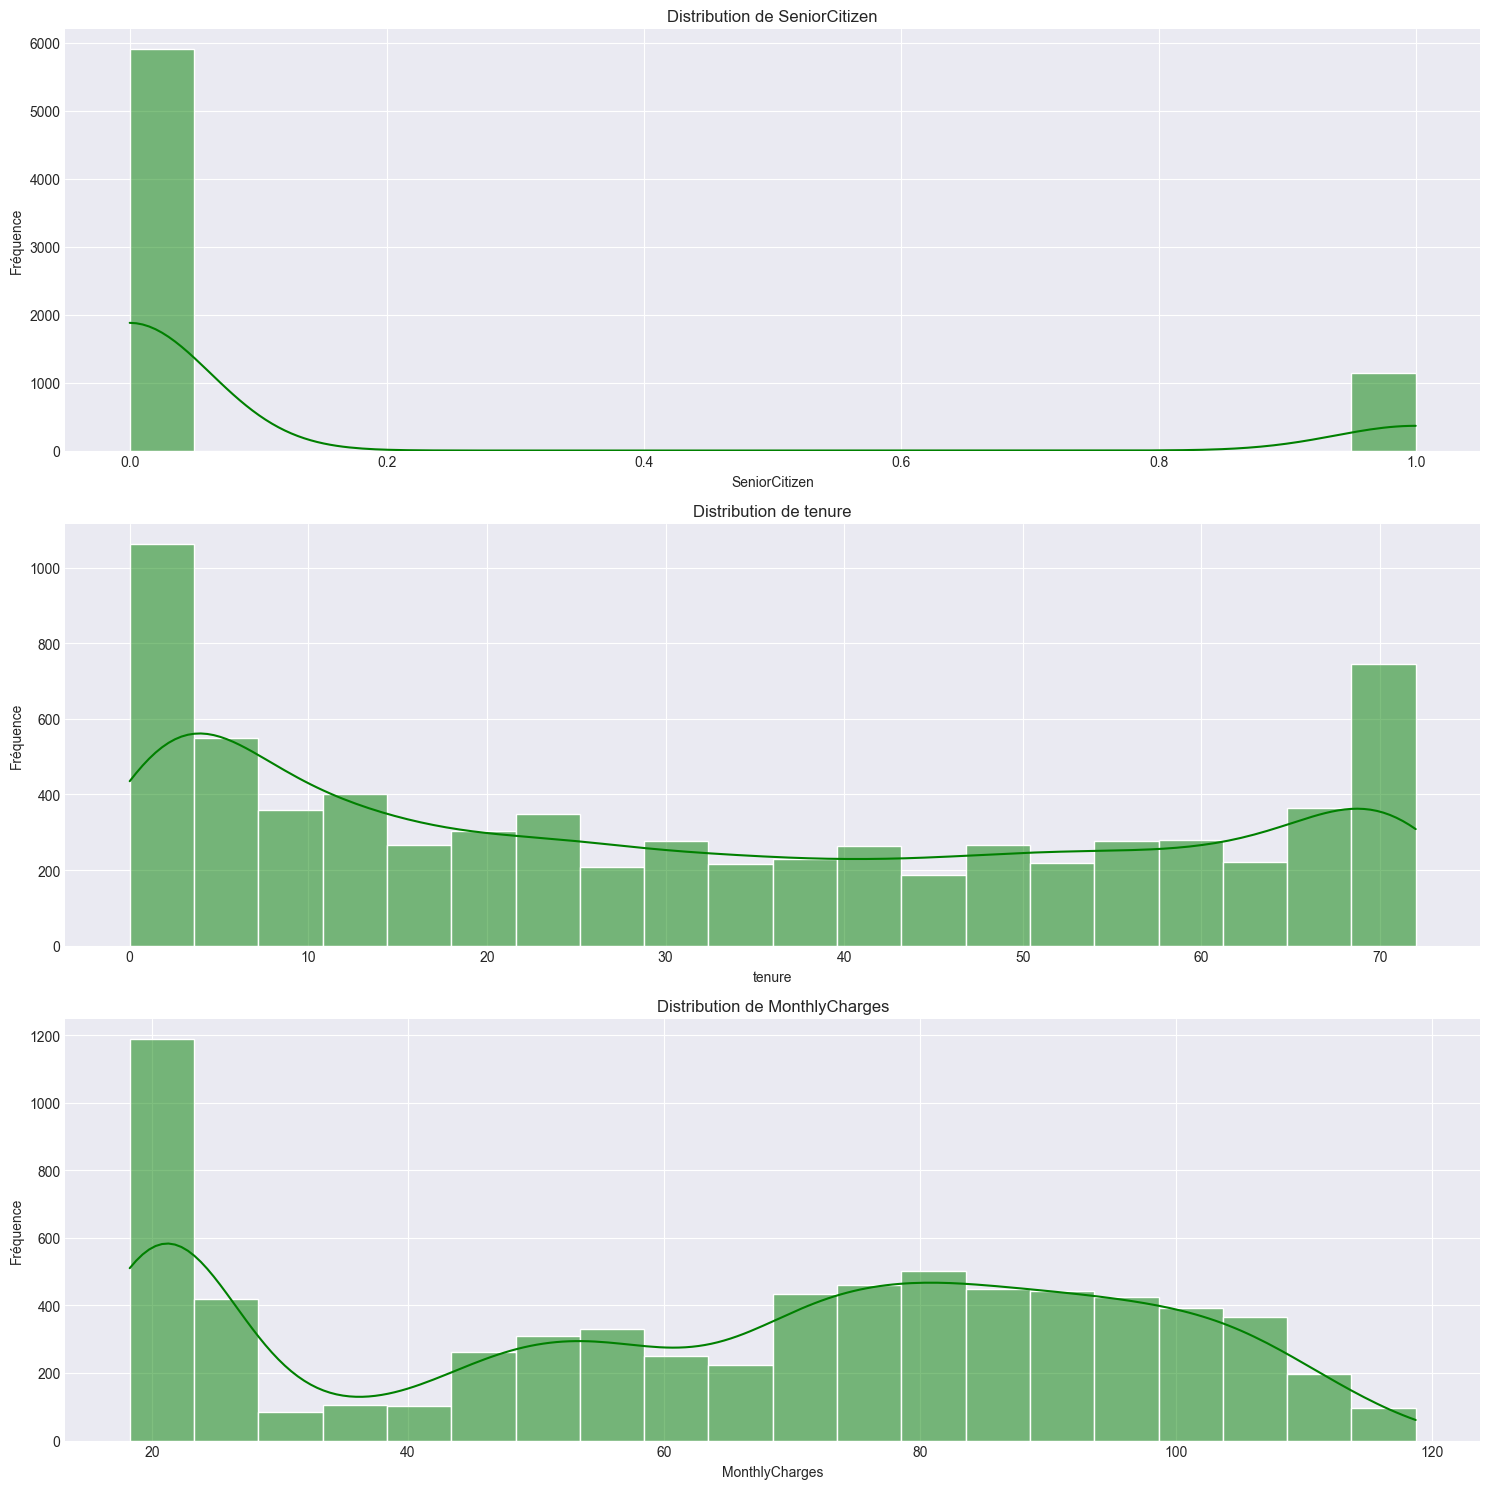

In [79]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(15, 5 * len(numeric_cols)))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.histplot(data[col], kde=True, bins=20, color='green')
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")

plt.tight_layout()
plt.show()

Diagramme en barre pour les variables categorielles


📊 DIAGRAMMES EN BARRES POUR LES VARIABLES CATÉGORIELLES


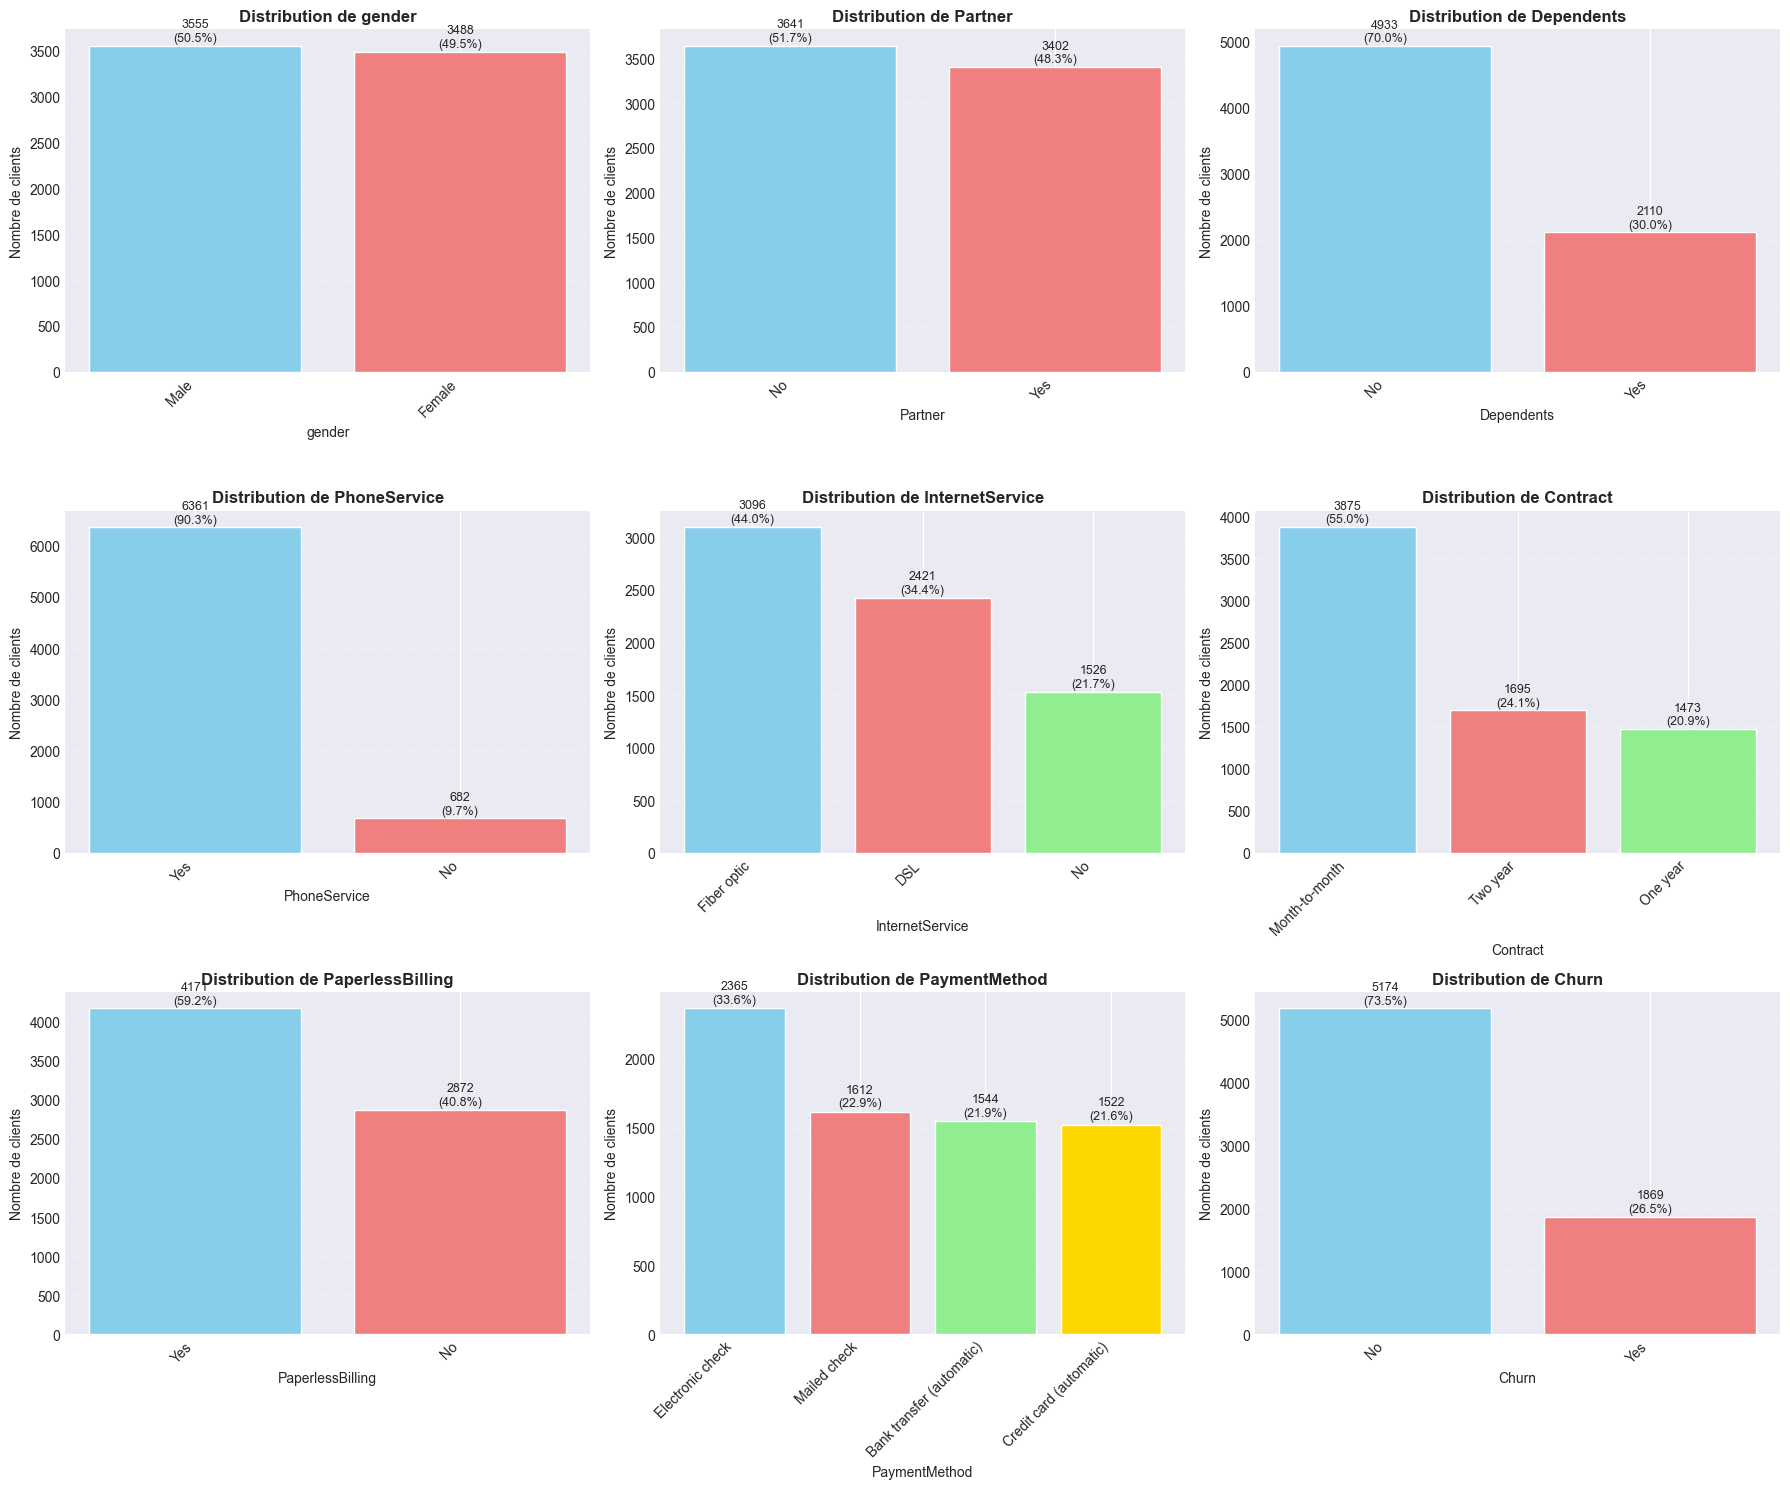


🎯 DISTRIBUTION DU CHURN PAR RAPPORT À D'AUTRES VARIABLES


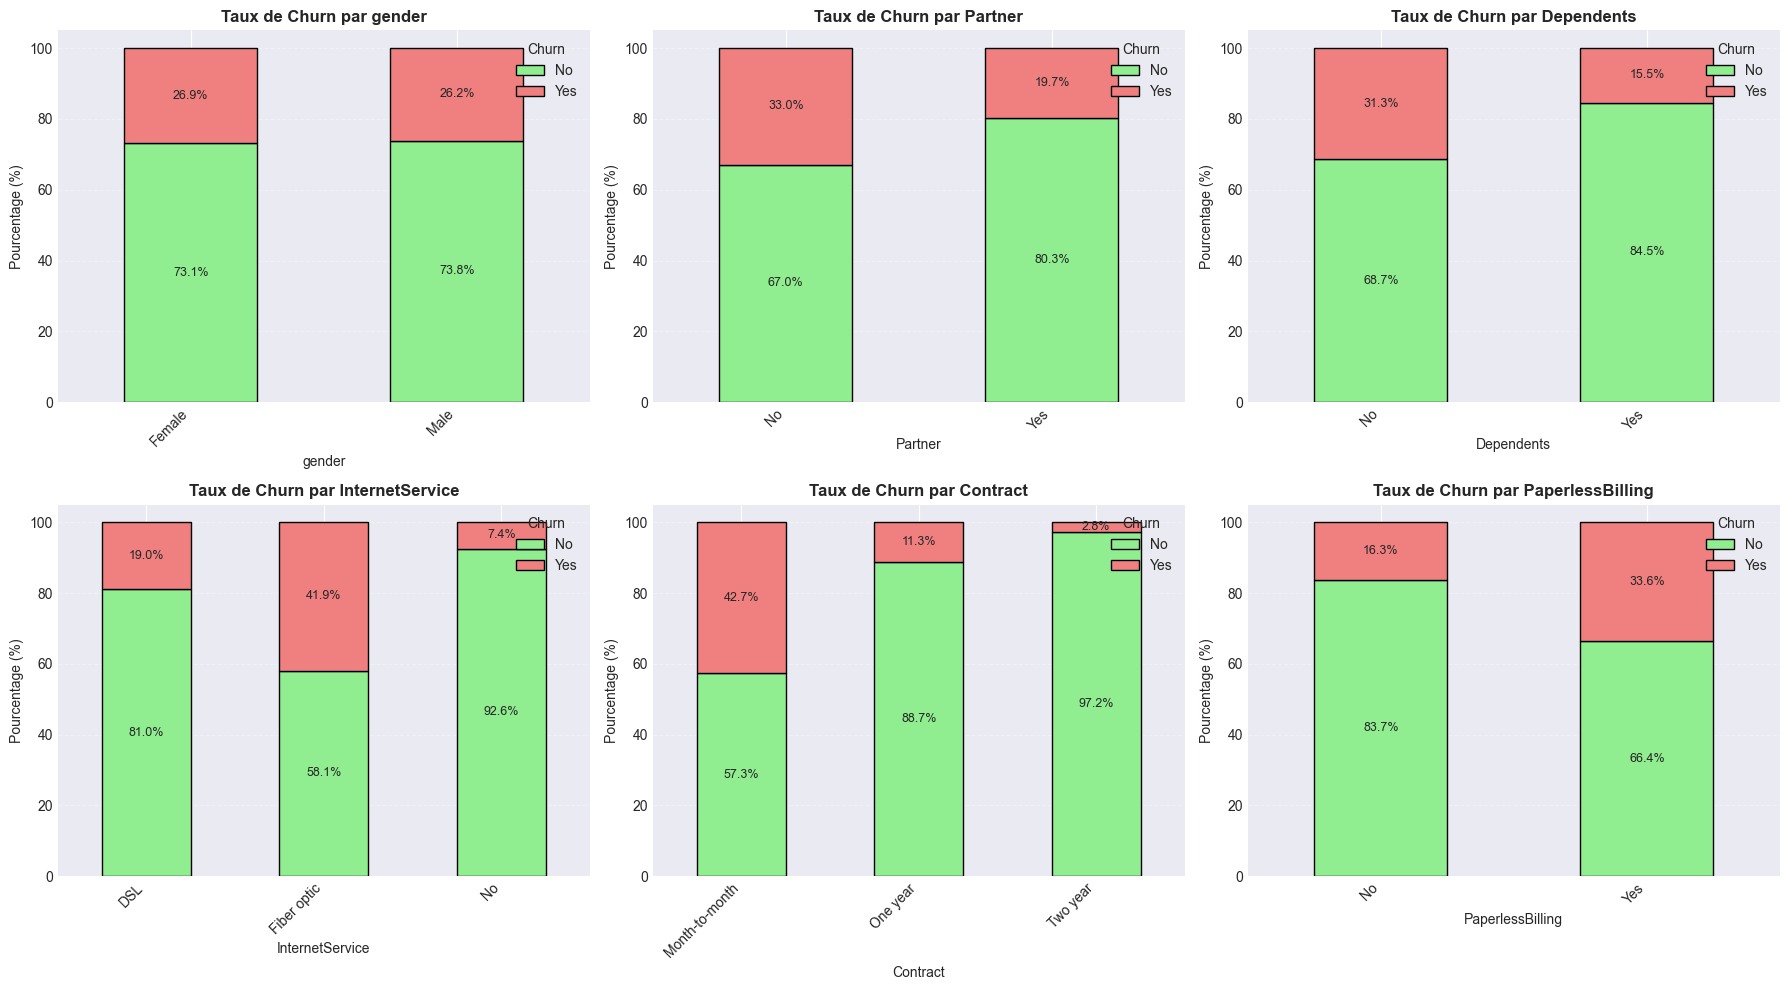

In [80]:
# DIAGRAMMES EN BARRES POUR LES VARIABLES CATÉGORIELLES IMPORTANTES
print("\n📊 DIAGRAMMES EN BARRES POUR LES VARIABLES CATÉGORIELLES")

# Sélection des variables catégorielles importantes (sans customerID et TotalCharges qui seront traitées séparément)
cat_cols_to_plot = ['gender', 'Partner', 'Dependents', 'PhoneService',
                    'InternetService', 'Contract', 'PaperlessBilling',
                    'PaymentMethod', 'Churn']

# Création d'une figure avec plusieurs subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(cat_cols_to_plot):
    # Compter les valeurs et calculer les pourcentages
    counts = data[col].value_counts()
    percentages = (counts / counts.sum() * 100).round(1)

    # Créer le graphique à barres
    bars = axes[i].bar(range(len(counts)), counts.values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(counts)])
    axes[i].set_title(f'Distribution de {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Nombre de clients')

    # Ajouter les étiquettes avec les pourcentages
    for idx, (bar, count, perc) in enumerate(zip(bars, counts.values, percentages.values)):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                    f'{count}\n({perc}%)', ha='center', va='bottom', fontsize=9)

    # Personnaliser les axes x
    axes[i].set_xticks(range(len(counts)))
    axes[i].set_xticklabels(counts.index, rotation=45, ha='right')

    # Ajouter une grille pour faciliter la lecture
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')

# Ajuster l'espacement
plt.tight_layout()
plt.show()

# Distribution de la variable cible Churn par rapport à d'autres variables catégorielles
print("\n🎯 DISTRIBUTION DU CHURN PAR RAPPORT À D'AUTRES VARIABLES")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Variables pour l'analyse croisée avec Churn
cross_cols = ['gender', 'Partner', 'Dependents', 'InternetService', 'Contract', 'PaperlessBilling']

for i, col in enumerate(cross_cols):
    # Créer un tableau croisé
    cross_tab = pd.crosstab(data[col], data['Churn'], normalize='index') * 100

    # Créer le graphique à barres empilées
    cross_tab.plot(kind='bar', stacked=True, ax=axes[i],
                   color=['lightgreen', 'lightcoral'], edgecolor='black')

    axes[i].set_title(f'Taux de Churn par {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Pourcentage (%)')
    axes[i].legend(title='Churn', loc='upper right')
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')

    # Rotation des étiquettes x
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

    # Ajouter les valeurs sur les barres
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.1f%%', label_type='center', fontsize=9)

plt.tight_layout()
plt.show()

Matrice de correlation pour identifier les relatioons entre variables


ÉTAPE 3 : MATRICE DE CORRÉLATION


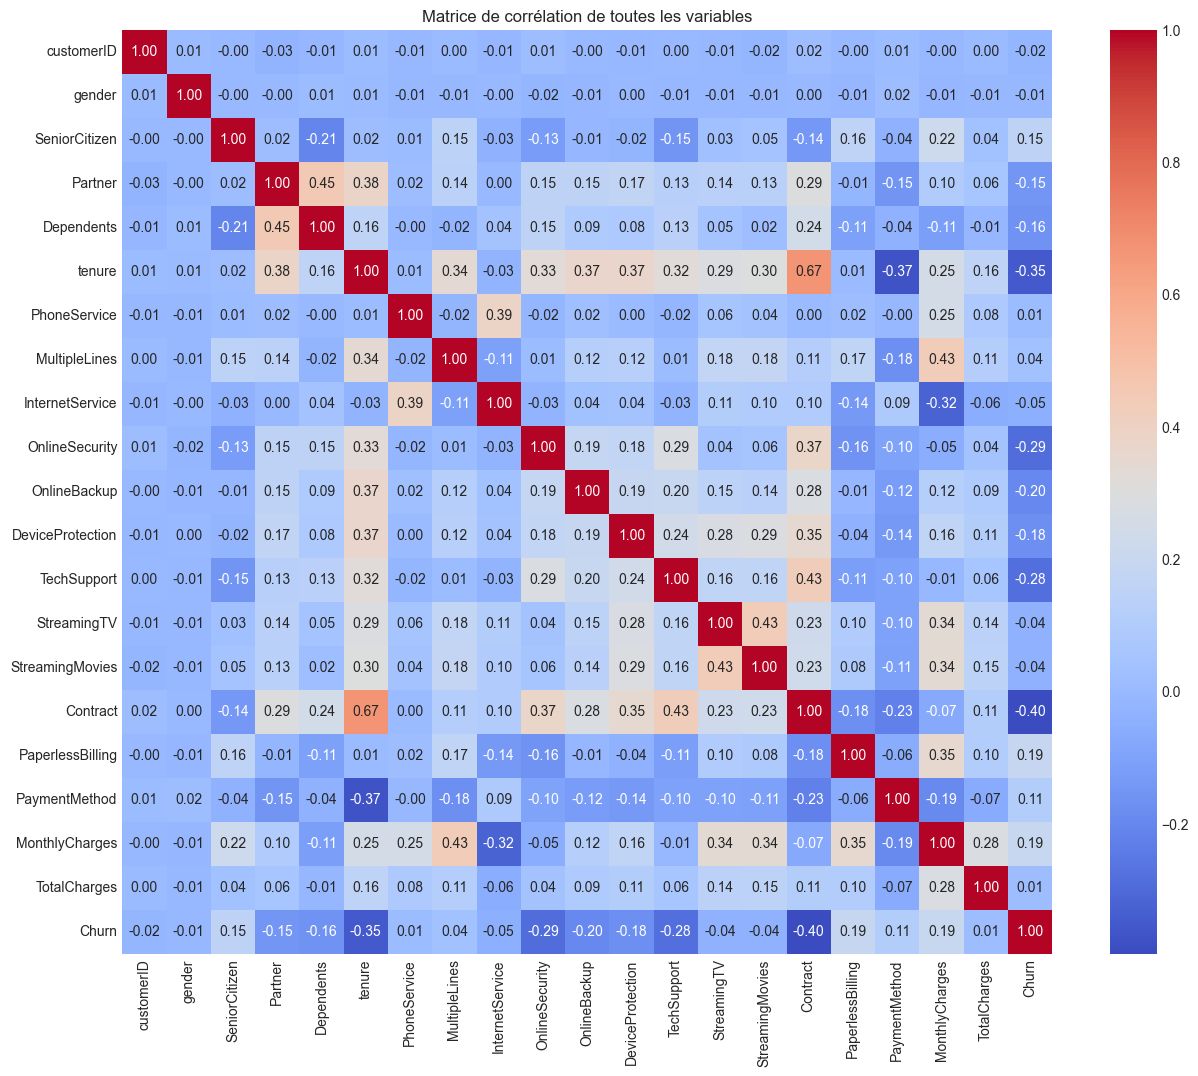

In [81]:

print("\n" + "=" * 80)
print("ÉTAPE 3 : MATRICE DE CORRÉLATION")
print("=" * 80)


df_corr = data.copy()




from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df_corr.select_dtypes(include=['object']).columns:
    df_corr[col] = le.fit_transform(df_corr[col])




corr_matrix = df_corr.corr()




plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation de toutes les variables")
plt.show()

Boxplots pour repérer les valeurs aberrantes

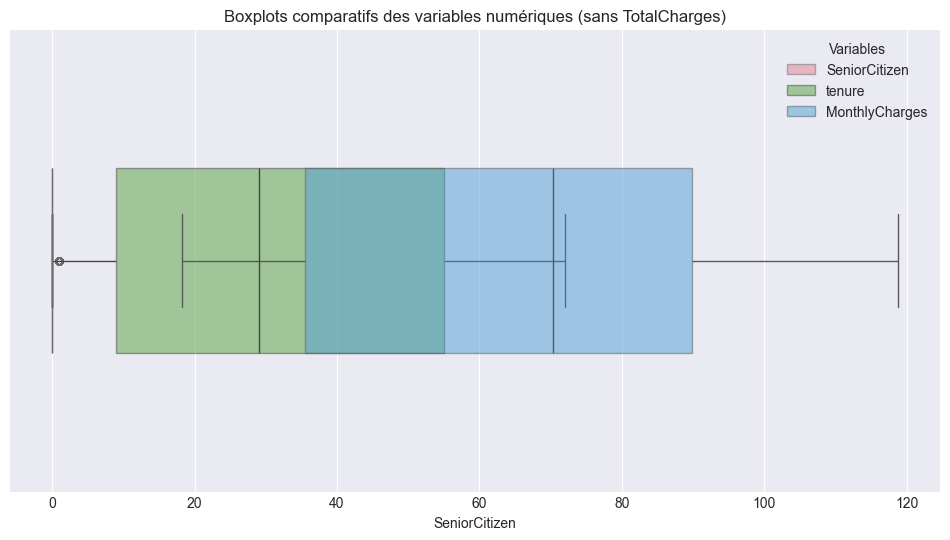

In [82]:
plt.figure(figsize=(12,6))


cols_to_plot = [col for col in numerical_cols if col != 'TotalCharges']


colors = sns.color_palette("husl", len(cols_to_plot))

for i, col in enumerate(cols_to_plot):
    sns.boxplot(x=data[col], color=colors[i], width=0.4, fliersize=5, boxprops=dict(alpha=0.5), label=col)

plt.legend(title="Variables")
plt.title("Boxplots comparatifs des variables numériques (sans TotalCharges)")
plt.show()

============================================================================

ÉTAPE 3 : NETTOYAGE ET PRÉPARATION DES DONNÉES

============================================================================

============================================================================

 ÉTAPE 4 : Comprendre les méthodologies

============================================================================

| KDD | SEMMA | CRISP-DM |
|--------|-----------|---------------|
| Sélection : Chargement du dataset, choix des variables | Sample : Sélection ou chargement de l’échantillon de données | Business Understanding : Comprendre le problème (ex : churn) |
| Prétraitement : Gestion des valeurs manquantes, nettoyage | Explore : Analyse exploratoire, statistiques, corrélations, boxplots | Data Understanding : Exploration des données, description des variables |
| Transformation : Standardisation, normalisation, encoding | Modify : Transformation, nettoyage, normalisation des données | Data Preparation : Étape 3 (nettoyage + transformation) |
| Data Mining : Modélisation (clustering, classification) | Model : Construction des modèles ML | Modeling : Entraînement des modèles |
| Interprétation : Visualisation, analyse des résultats | Assess : Évaluation des performances | Evaluation : Accuracy, recall, silhouette, ARI… |
| — | — | Deployment (pas fait ici) |


In [83]:
dat = {
    "KDD": [
        "Sélection des données (Étape 1 : chargement du dataset)",
        "Prétraitement (Étape 3 : nettoyage, valeurs manquantes)",
        "Transformation (standardisation, encoding)",
        "Data Mining (modélisation : clustering ou classification)",
        "Interprétation (analyse des résultats, visualisations)"
    ],
    "SEMMA": [
        "Sample : échantillonnage / chargement du dataset",
        "Explore : statistiques, valeurs manquantes, boxplots",
        "Modify : nettoyage, transformation, normalisation",
        "Model : entraînement des modèles ML",
        "Assess : évaluation (accuracy, silhouette, ARI…) "
    ],
    "CRISP-DM": [
        "Business Understanding (comprendre le problème du churn)",
        "Data Understanding (exploration, variables, corrélation)",
        "Data Preparation (Étape 3 : nettoyage + transformation)",
        "Modeling (création des modèles ML)",
        "Evaluation (scores : accuracy, recall, silhouette…) ",
        "Deployment (non réalisé ici — option futur projet)"
    ]
}

df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in dat.items()]))

print(df)

                                                 KDD  \
0  Sélection des données (Étape 1 : chargement du...   
1  Prétraitement (Étape 3 : nettoyage, valeurs ma...   
2         Transformation (standardisation, encoding)   
3  Data Mining (modélisation : clustering ou clas...   
4  Interprétation (analyse des résultats, visuali...   
5                                                NaN   

                                               SEMMA  \
0   Sample : échantillonnage / chargement du dataset   
1  Explore : statistiques, valeurs manquantes, bo...   
2  Modify : nettoyage, transformation, normalisation   
3                Model : entraînement des modèles ML   
4  Assess : évaluation (accuracy, silhouette, ARI…)    
5                                                NaN   

                                            CRISP-DM  
0  Business Understanding (comprendre le problème...  
1  Data Understanding (exploration, variables, co...  
2  Data Preparation (Étape 3 : nettoyage + transf

Partie II – Machine Learning en pratique

A) Régression linéaire

1. Préparer les données

Séparer en 80% entraînement et 20% test

In [85]:
# 1. Définition de X et y
X = data.drop(columns=["Churn"])   # Toutes les variables sauf la colonne cible
y = data["Churn"]                  # Variable cible

# 2. Découpage train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test :", y_test.shape)

X_train : (5634, 20)
X_test : (1409, 20)
y_train : (5634,)
y_test : (1409,)


 3Entraînement du modèle

In [89]:
# ==========================================================
#   TELCO CHURN - PIPELINE COMPLET : ENCODAGE + MODELISATION
# ==========================================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ================================
# 1. Chargement du Dataset
# ================================


print("Dataset chargé. Dimensions :", data.shape)
print(data.head())

# ================================
# 2. Encodage des variables catégorielles
# ================================
data_encoded = pd.get_dummies(data, drop_first=True)

print("\nEncodage terminé. Nouvelles dimensions :", data_encoded.shape)

# ================================
# 3. Définition X et y
# ================================
y = data_encoded["Churn_Yes"]      # colonne cible (après get_dummies)
X = data_encoded.drop(columns=["Churn_Yes"])

# ================================
# 4. Train/Test Split
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nDécoupage terminé :")
print("X_train :", X_train.shape)
print("X_test  :", X_test.shape)
print("y_train :", y_train.shape)
print("y_test  :", y_test.shape)

# ================================
# 5. Modèle RandomForest
# ================================
model = RandomForestClassifier(random_state=42)

print("\nEntraînement du modèle...")
model.fit(X_train, y_train)

# ================================
# 6. Prédiction + Évaluation
# ================================
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("\n==============================")
print("       ÉVALUATION")
print("==============================")
print(f"Accuracy : {accuracy:.4f}")
print("\nClassification Report :\n", classification_report(y_test, y_pred))
print("Confusion Matrix :\n", confusion_matrix(y_test, y_pred))

Dataset chargé. Dimensions : (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  

Création du modèle